In [18]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
gridmet = catalog.get_collection("gridmet")
asset = planetary_computer.sign(gridmet.assets["zarr-abfs"])
asset

<Asset href=abfs://gridmet/gridmet.zarr>

In [19]:
import fsspec
import xarray as xr

store = fsspec.get_mapper(asset.href, **asset.extra_fields["xarray:storage_options"])
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds

<xarray.Dataset>
Dimensions:                                    (time: 15341, lat: 585,
                                                lon: 1386, crs: 1)
Coordinates:
  * crs                                        (crs) uint16 3
  * lat                                        (lat) float64 49.4 ... 25.07
  * lon                                        (lon) float64 -124.8 ... -67.06
  * time                                       (time) datetime64[ns] 1979-01-...
Data variables:
    air_temperature                            (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    burning_index_g                            (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    dead_fuel_moisture_1000hr                  (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    dead_fuel_moisture_100hr                   (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    mean_vapor_pressure_deficit                (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    potential_evapotranspiration               (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    precipitation_amount                       (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    relative_humidity                          (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    specific_humidity                          (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    surface_downwelling_shortwave_flux_in_air  (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    wind_from_direction                        (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
    wind_speed                                 (time, lat, lon) float32 dask.array<chunksize=(30, 585, 1386), meta=np.ndarray>
Attributes: (12/19)
    Conventions:                CF-1.6
    author:                     John Abatzoglou - University of Idaho, jabatz...
    coordinate_system:          EPSG:4326
    date:                       02 July 2019
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_bounds_crs:      EPSG:4326
    ...                         ...
    geospatial_lon_units:       decimal_degrees east
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...

epsg:3857
<class 'geopandas.geodataframe.GeoDataFrame'>
epsg:3857


<AxesSubplot:>

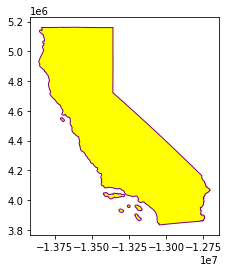

In [27]:
import geopandas as gpd

ca_shape_path = "/home/jovyan/Sedgwick_Reserve/CA_geometry/CA_State_TIGER2016.shp"
ca_shape = gpd.read_file(ca_shape_path)
print(ca_shape.crs)
print(type(ca_shape))
print(ca_shape.crs)
ca_shape.plot(edgecolor='purple', color='yellow')

<AxesSubplot:>

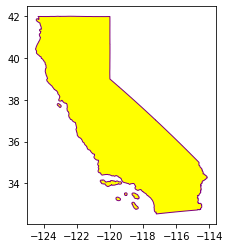

In [28]:
# match CRS
crs= ds.attrs['coordinate_system']
ca_match = ca_shape.to_crs(ds.attrs['coordinate_system'])
ca_match.plot(edgecolor='purple', color='yellow')

In [4]:
import calendar
print(calendar.isleap(1900))

False


In [22]:
# given month,year returns the dates of the first and last day of the month
# ex: (month=12, year=2001) returns (2001-12-01, 2002-01-01)
def string_date(month,year):
    if month in (1,3,5,7,8,10,12):
        return str(year)+'-'+str(month)+'-01',str(year)+'-'+str(month)+'-31'
    if month in (4,6,9,11):
        return str(year)+'-'+str(month)+'-01',str(year)+'-'+str(month)+'-30'
    if calendar.isleap(year):
        return str(year)+'-02-01',str(year)+'-02-29'
    return str(year)+'-02-01',str(year)+'-02-28'

def month_end(month,year):
    if month in (1,3,5,7,8,10,12):
        return str(year)+'-'+str(month)+'-31'
    if month in (4,6,9,11):
        return str(year)+'-'+str(month)+'-30'
    if calendar.isleap(year):
        return str(year)+'-2-29'
    return str(year)+'-2-28'

def month_start(month,year):
    return str(year)+'-'+str(month)+'-1'

In [ ]:
def str_yr_start(year):
    return str(year)+'-01-01'
def str_yr_end(year):
    return str(year)+'-12-31'

In [ ]:
def month_aridity_index(month,year,evap,prec):
    m_prec = prec.sel(time=slice(month_start(month,year),month_end(month,year)))
    m_evap = evap.sel(time=slice(month_start(month,year),month_end(month,year)))
    
    total_prec = m_prec.sum(dim='time', keep_attrs = True)
    total_evap = m_evap.sum(dim='time', keep_attrs = True)
    
    return total_prec/total_evap

def aridity_index(year,n,ca_shp):
    crs = ds.attrs['coordinate_system']
    ca_match = ca_shape.to_crs(crs)
    
    prec = ds["precipitation_amount"].sel(time=slice(str(year-n+1)+'-01-01',str(year)+'-12-31'))
    evap = ds["potential_evapotranspiration"].sel(time=slice(str(year-n+1)+'-01-01',str(year)+'-12-31'))
    
    prec = prec.rio.write_crs(crs)
    ca_prec = prec.rio.clip(ca_match.geometry, ca_match.crs)
    evap = evap.rio.write_crs(crs)
    ca_evap = evap.rio.clip(ca_match.geometry, ca_match.crs)
    
#    stack = month_aridity_index(1,year,evap,prec)
    for i in range(1,13):
        for j in range(year-n+1,year+1):
            



    
    

In [24]:
prec= ds["precipitation_amount"].sel(time=slice('2020-01-01','2020-12-31'))
prec

<xarray.DataArray 'precipitation_amount' (time: 366, lat: 585, lon: 1386)>
dask.array<getitem, shape=(366, 585, 1386), dtype=float32, chunksize=(30, 585, 1386), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 49.4 49.36 49.32 49.28 ... 25.19 25.15 25.11 25.07
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -67.14 -67.1 -67.06
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
Attributes:
    coordinate_system:  WGS84,EPSG:4326
    description:        Daily Accumulated Precipitation
    dimensions:         lon lat time
    grid_mapping:       crs
    long_name:          pr
    standard_name:      pr
    units:              mm

In [32]:
prec = prec.rio.write_crs(crs)
ca_prec_2020 = prec.rio.clip(ca_match.geometry, ca_match.crs)
ca_prec_2020 

<xarray.DataArray 'precipitation_amount' (time: 366, lat: 227, lon: 249)>
dask.array<getitem, shape=(366, 227, 249), dtype=float32, chunksize=(30, 227, 249), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
    crs      int64 0
Attributes:
    coordinate_system:  WGS84,EPSG:4326
    description:        Daily Accumulated Precipitation
    dimensions:         lon lat time
    grid_mapping:       crs
    long_name:          pr
    standard_name:      pr
    units:              mm

In [35]:
ca_prec1 = ca_prec.sel(time=slice('2020-01-01','2020-01-31'))
#ca_prec1

In [34]:
ca_prec3 = ca_prec.sel(time=slice('2020-03-01','2020-03-31'))
#ca_prec3

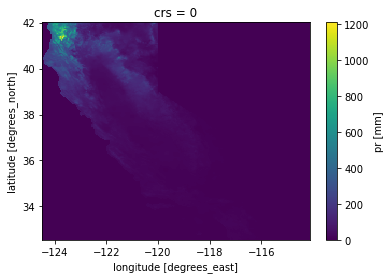

In [41]:
#t_prec1 = ca_prec1.sum(dim='time', keep_attrs = True)
t_prec1.plot()

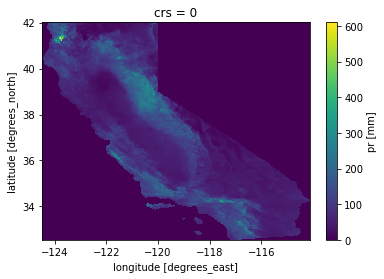

In [42]:
#t_prec3 = ca_prec3.sum(dim='time', keep_attrs = True)
t_prec3.plot()

In [51]:
stack = xr.concat([t_prec1,t_prec3],dim='time',combine_attrs = 'drop')
stack

<xarray.DataArray 'precipitation_amount' (time: 2, lat: 227, lon: 249)>
dask.array<concatenate, shape=(2, 227, 249), dtype=float32, chunksize=(1, 227, 249), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1
    crs      int64 0
Dimensions without coordinates: time

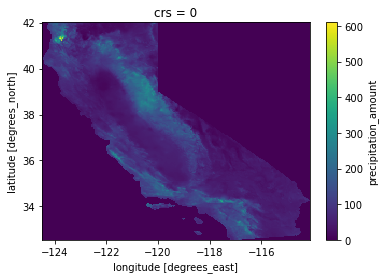

In [54]:
stack.sel(time=1).plot()

In [ ]:
#total_precip.plot()

In [ ]:
ds["potential_evapotranspiration"]

In [ ]:
evap_years= ds["potential_evapotranspiration"].sel(time=slice(str_yr_start(1979),str_yr_end(2009)))
evap_years

In [ ]:
evap_years = evap_years.rio.write_crs(crs)
ca_evap_years = evap_years.rio.clip(ca_match.geometry, ca_match.crs)
ca_evap_years

In [ ]:
total_evap = ca_evap_years.sum(dim='time', keep_attrs = True)
total_evap

In [ ]:
total_evap.plot()

In [ ]:
arid_index = total_precip/(365*total_evap)

In [ ]:
arid_index.plot()

In [ ]:
import numpy as np

# extract numpy.ndarray
arid_rgns = arid_index.to_numpy()
# establish thresholds
k = [0.05,0.65]

arid_rgns[np.where( arid_rgns< k[0])] = 1
arid_rgns[np.where( (k[0]<=arid_rgns) & (arid_rgns<k[1]))] = 2
arid_rgns[np.where(k[1]<=arid_rgns)] = 3

import matplotlib.pyplot as plt
plt.imshow(arid_rgns)

This is wrong D: 
We need to either calculate AI for each month and average all of those, or calculate it for each year and average all of those. 
https://github.com/carmengg/CA_combinatorial_ecosystems/blob/main/python_scripts/aridity/aridity_workflow.ipynb
Check the workflow there and follow either that, or the calculation of normals by the WMO. 